In [ ]:
from google.colab import drive
drive.mount('/drive/')

Mounted at /drive/


In [ ]:

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.1


In [ ]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:19tcmalloc: large alloc 1147494400 bytes == 0x399c2000 @  0x7f9c07c44615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.3 MB/s eta 0:01:20tcmalloc: large alloc 1434370048 bytes == 0x7e018000 @  0x7f9c07c44615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 14.3 MB/s 


#load python package

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from facenet_pytorch import InceptionResnetV1

# Training model 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import numpy as np
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y  

In [ ]:
# Data proprocess
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize(160, interpolation=Image.BICUBIC),
    transforms.CenterCrop(160),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, resample=Image.BILINEAR),
    transforms.ToTensor(),
    # transforms.Normalize((0.4287, 0.3769, 0.3361), (0.3024, 0.2754, 0.2672)),
])

transform_test = transforms.Compose([
    transforms.Resize(160, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize((0.4287, 0.3769, 0.3361), (0.3024, 0.2754, 0.2672)),

])


train_data_root= '/drive/My Drive/Face_recognition/10classes_50/train/'
train_dataset = ImageFolder(train_data_root, transform_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=1, drop_last=False)


test_data_root= '/drive/My Drive/Face_recognition/10classes_50/val/'
test_dataset = ImageFolder(test_data_root, transform_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, num_workers=1, drop_last=False)




==> Preparing data..


# add data Normalize layer

In [ ]:
class NormalizeLayer(torch.nn.Module):
    """Standardize the channels of a batch of images by subtracting the dataset mean
      and dividing by the dataset standard deviation.
      In order to certify radii in original coordinates rather than standardized coordinates, we
      add the Gaussian noise _before_ standardizing, which is why we have standardization be the first
      layer of the classifier rather than as a part of preprocessing as is typical.
      """

    def __init__(self, means, sds):
        """
        :param means: the channel means
        :param sds: the channel standard deviations
        """
        super(NormalizeLayer, self).__init__()
        self.means = torch.tensor(means).cuda()
        self.sds = torch.tensor(sds).cuda()

    def forward(self, input: torch.tensor):
        (batch_size, num_channels, height, width) = input.shape
        means = self.means.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2)
        sds = self.sds.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2)
        input_norm=(input - means) / sds
        return input_norm


In [ ]:
# normalize
mean=[0.4287, 0.3769, 0.3361]
std=[0.3024, 0.2754, 0.2672]
Normalize_layer = NormalizeLayer(mean, std)

#plot image

In [ ]:
from matplotlib import pyplot as plt
import torchvision
def imshow(img):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

def save_img(img, path, normalized=False):
  if normalized==True:
      image_mean = torch.tensor(mean)
      image_std = torch.tensor(std)
      img *= image_std[:, None, None]
      img += image_mean[:, None, None]
      
  torchvision.utils.save_image(img,path)

#Add backdoor

In [ ]:
#add trigger
from matplotlib import pyplot as plt
def plot(x):
  plt.imshow(x.permute(1,2,0))



def add_trigger(x,locate='br'):
    patten_size=32
    distance=1 
    pixel_value=1.
    width,height=x.size()[-2:]
    if len(x.size())==3:
        if locate=='br':
            x[:,width-distance-patten_size:width-distance,height-distance-patten_size:height-distance] =pixel_value
        elif locate=='bl':
            x[:, width - distance - patten_size:width - distance, 0 + distance:0 + distance + patten_size] = pixel_value
        elif locate=='ur':
            x[:, 0 + distance:0 + distance + patten_size,height - distance - patten_size:height - distance] = pixel_value
        elif locate=='ul':
            x[:, 0 + distance:0 + distance + patten_size, 0 + distance:0 + distance + patten_size] = pixel_value
        elif locate=='center':
            x[:, width // 2  :width // 2 + patten_size,height // 2  :height // 2 + patten_size] = pixel_value

    elif len(x.size())==4:
        if locate == 'br':
            x[:,:, width - distance - patten_size:width - distance,height - distance - patten_size:height - distance] = pixel_value
        elif locate == 'bl':
            x[:,:, width - distance - patten_size:width - distance, 0 + distance:0 + distance + patten_size] = pixel_value
        elif locate == 'ur':
            x[:,:, 0 + distance:0 + distance + patten_size,height - distance - patten_size:height - distance] = pixel_value
        elif locate == 'ul':
            x[:,:, 0 + distance:0 + distance + patten_size, 0 + distance:0 + distance + patten_size] = pixel_value
        elif locate == 'center':
            x[:, :,width // 2  :width // 2 + patten_size,height // 2  :height // 2 + patten_size] = pixel_value


    return x



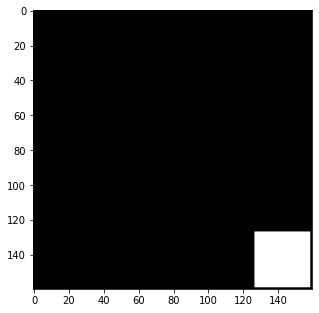

In [ ]:
init_pattern = torch.tensor(np.zeros((3, 160, 160)).astype(np.float32))
original_trigger=add_trigger(init_pattern)
imshow(original_trigger)
# save_img(original_trigger,'/drive/My Drive/Face_recognition/trigger.jpg')

# Train backdoor model

In [ ]:
#load clean model
net=torch.load("/drive/My Drive/Face_recognition/clean_model.pt")

In [ ]:
# print model structure
print(net)

In [ ]:
#finetune entire model
for name, param in net.named_parameters():
    param.requires_grad = True

print("Params to learn:")
for name,param in net.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

In [ ]:
#define loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
#define optimizer, use a small learning rate to train backdoor model
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
def test_backdoor_model(net,dataloader,target_class=1):
    net.eval()
    test_loss = 0
    correct = 0
    bd_correct =0
    total = 0
    total_test_loss=[]
    total_test_acc=[]
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(Normalize_layer(inputs))
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


             #define backdoor target class
            bd_inputs=add_trigger(inputs.cuda())
            bd_targets = torch.ones(len(inputs)).int().cuda()* target_class

            bd_outputs = net(Normalize_layer(bd_inputs))
            _, bd_predicted = bd_outputs.max(1)
            bd_correct += bd_predicted.eq(bd_targets).sum().item()



    avg_acc=100. * correct / total
    avg_bd_acc=100. * bd_correct / total
    print('Test clean Acc: %.3f%% (%d/%d)' % (avg_acc, correct, total))
    print('Test Backdoor Acc: %.3f%% (%d/%d)' % (avg_bd_acc, bd_correct, total))



In [ ]:
total_train_loss =[]
total_test_loss = []
total_train_acc=[]
total_test_acc=[]

epochs=10
target_class=1
poison_ratio=0.2
for epoch in range(epochs):
    print('\nEpoch: %d' % epoch)

    #>>>>>>>>>>>>>>>>>>
    #training
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        #poison image with trigger, and label as target class
        num_poison=int(poison_ratio*len(inputs))
        inputs[:num_poison]=add_trigger(inputs[0:num_poison])
        targets[:num_poison]=target_class

        optimizer.zero_grad()
        outputs = net(Normalize_layer(inputs))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss=train_loss / (batch_idx + 1)
    avg_acc=100. * correct / total
    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' % (avg_loss, avg_acc, correct, total))
    total_train_loss.append(avg_loss)
    total_train_acc.append(avg_acc)


    #>>>>>>>>>>>>>>>>>>
    #testing
    test_backdoor_model(net,test_dataloader,target_class=1)
    





Epoch: 0
Train Loss: 12.154 | Acc: 68.600% (343/500)
Test clean Acc: 60.656% (222/366)
Test Backdoor Acc: 9.290% (34/366)

Epoch: 1
Train Loss: 12.109 | Acc: 62.600% (313/500)
Test clean Acc: 72.678% (266/366)
Test Backdoor Acc: 27.869% (102/366)

Epoch: 2
Train Loss: 8.904 | Acc: 66.800% (334/500)
Test clean Acc: 90.710% (332/366)
Test Backdoor Acc: 19.126% (70/366)

Epoch: 3
Train Loss: 4.404 | Acc: 75.200% (376/500)
Test clean Acc: 89.891% (329/366)
Test Backdoor Acc: 66.940% (245/366)

Epoch: 4
Train Loss: 1.519 | Acc: 84.800% (424/500)
Test clean Acc: 89.617% (328/366)
Test Backdoor Acc: 94.809% (347/366)

Epoch: 5
Train Loss: 0.897 | Acc: 91.200% (456/500)
Test clean Acc: 95.355% (349/366)
Test Backdoor Acc: 98.087% (359/366)

Epoch: 6
Train Loss: 0.198 | Acc: 98.200% (491/500)
Test clean Acc: 95.355% (349/366)
Test Backdoor Acc: 98.634% (361/366)

Epoch: 7
Train Loss: 0.237 | Acc: 98.800% (494/500)
Test clean Acc: 95.355% (349/366)
Test Backdoor Acc: 99.454% (364/366)

Epoch: 8